In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns


In [5]:
# Load the dataset
df = pd.read_csv("stackoverflow_full.csv")
df=df.dropna() #drop null values
df.drop(["Unnamed: 0"], inplace = True, axis =1 )
df.drop(columns = 'HaveWorkedWith', inplace=True) #mostly redundant with computerskills, it would be useful if I was breaking things down by individual programming languages

df.isnull().sum()



Age               0
Accessibility     0
EdLevel           0
Employment        0
Gender            0
MentalHealth      0
MainBranch        0
YearsCode         0
YearsCodePro      0
Country           0
PreviousSalary    0
ComputerSkills    0
Employed          0
dtype: int64

In [6]:
# Encode categorical variables
label_encoders = {}
for col in ['Age', 'Accessibility', 'MentalHealth', 'EdLevel', 'Gender', 'MainBranch', 'Country']:  
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for future transformations


df.head()

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,ComputerSkills,Employed
0,0,0,0,1,0,0,0,7,4,146,51552.0,4,0
1,0,0,4,1,0,0,0,12,5,141,46482.0,12,1
2,0,0,0,1,0,0,0,15,6,54,77290.0,7,0
3,0,0,4,1,0,0,0,9,6,27,46135.0,13,0
4,1,0,3,0,0,0,1,40,30,135,160932.0,2,0


In [7]:
# Define new predictor variables (excluding non-significant ones)
significant_predictors = ['EdLevel', 'Gender', 'YearsCodePro', 'PreviousSalary']

# Define new independent variable set
X = df[significant_predictors]
y = df['Employed']


## Box Plot

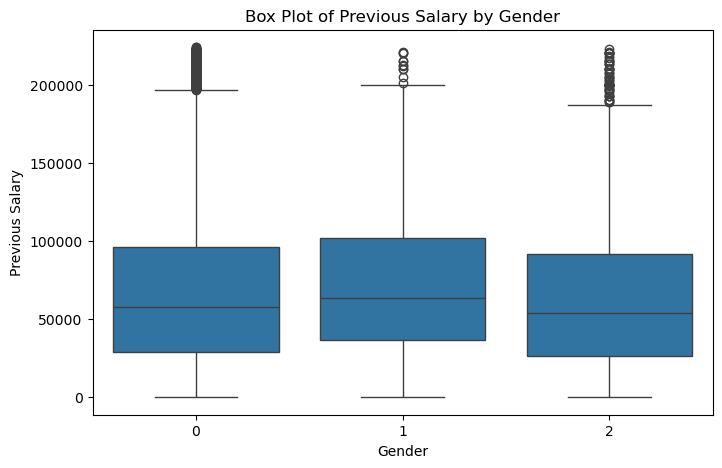

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Gender"], y=df["PreviousSalary"])
plt.title("Box Plot of Previous Salary by Gender")
plt.xlabel("Gender")
plt.ylabel("Previous Salary")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 68521.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk test for Male Salaries: p-value = 0.0000
Shapiro-Wilk test for Female Salaries: p-value = 0.0000


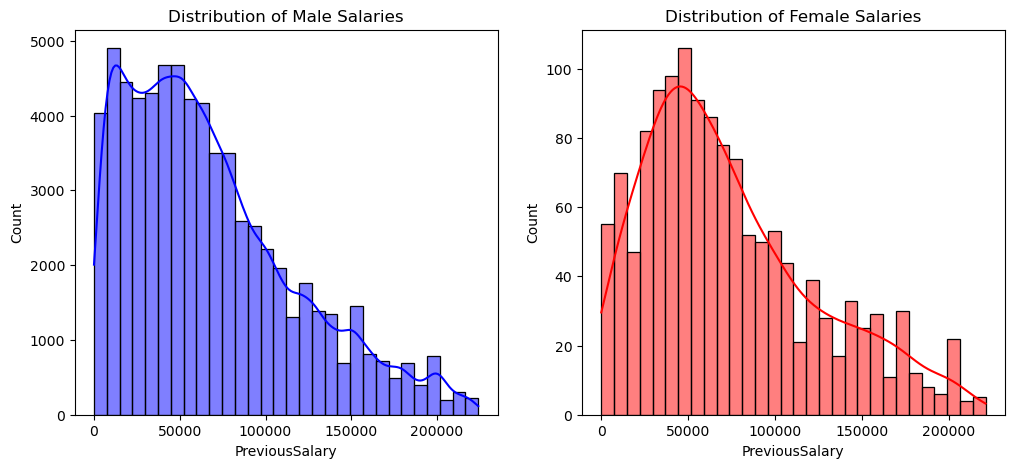

In [23]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Separate salaries by gender
male_salaries = df[df["Gender"] == 0]["PreviousSalary"]
female_salaries = df[df["Gender"] == 1]["PreviousSalary"]

# Shapiro-Wilk normality test
shapiro_male = stats.shapiro(male_salaries)
shapiro_female = stats.shapiro(female_salaries)

print(f"Shapiro-Wilk test for Male Salaries: p-value = {shapiro_male.pvalue:.4f}")
print(f"Shapiro-Wilk test for Female Salaries: p-value = {shapiro_female.pvalue:.4f}")

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(male_salaries, bins=30, kde=True, color="blue")
plt.title("Distribution of Male Salaries")

plt.subplot(1, 2, 2)
sns.histplot(female_salaries, bins=30, kde=True, color="red")
plt.title("Distribution of Female Salaries")

plt.show()


In [25]:
# Perform Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(male_salaries, female_salaries, alternative='two-sided')

# Print results
print(f"Mann-Whitney U test p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Statistically significant difference in salaries between genders.")
else:
    print("No statistically significant difference in salaries between genders.")


Mann-Whitney U test p-value: 0.0000
Statistically significant difference in salaries between genders.


C:\Users\NegimaSonic\AppData\Local\Temp\ipykernel_20112\2551345857.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(male_salaries, label="Male", shade=True, color="blue")
C:\Users\NegimaSonic\AppData\Local\Temp\ipykernel_20112\2551345857.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(female_salaries, label="Female", shade=True, color="red")


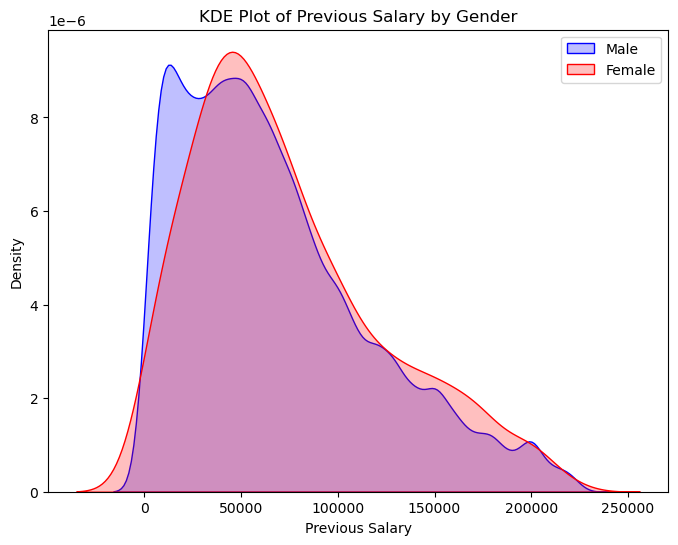

In [27]:
plt.figure(figsize=(8, 6))
sns.kdeplot(male_salaries, label="Male", shade=True, color="blue")
sns.kdeplot(female_salaries, label="Female", shade=True, color="red")
plt.title("KDE Plot of Previous Salary by Gender")
plt.xlabel("Previous Salary")
plt.ylabel("Density")
plt.legend()
plt.show()



## Correlation Matrix

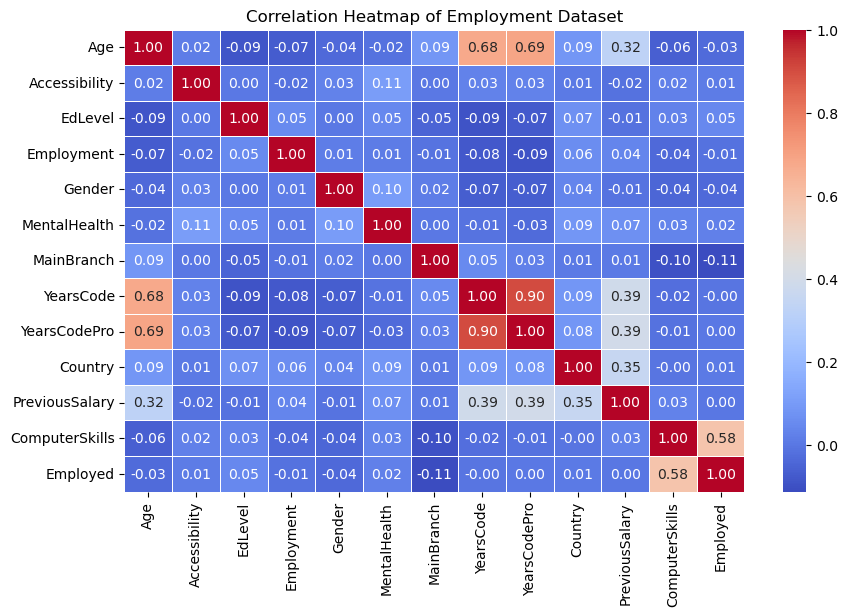

In [30]:
# Compute correlation matrix
corr_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Correlation Heatmap of Employment Dataset")

# Show plot
plt.show()

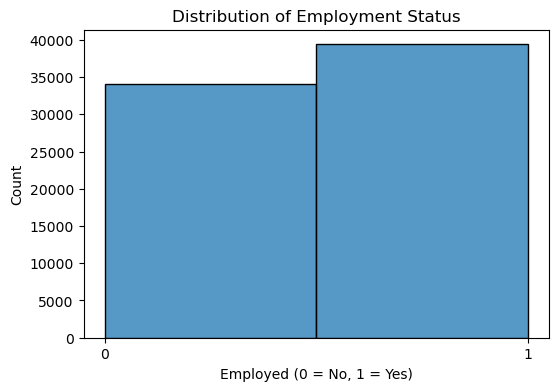

In [32]:
plt.figure(figsize=(6, 4))
sns.histplot(df["Employed"], bins=2, kde=False)
plt.title("Distribution of Employment Status")
plt.xlabel("Employed (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0, 1])
plt.show()


## Random forest

Random Forest Classifier Accuracy: 0.5188


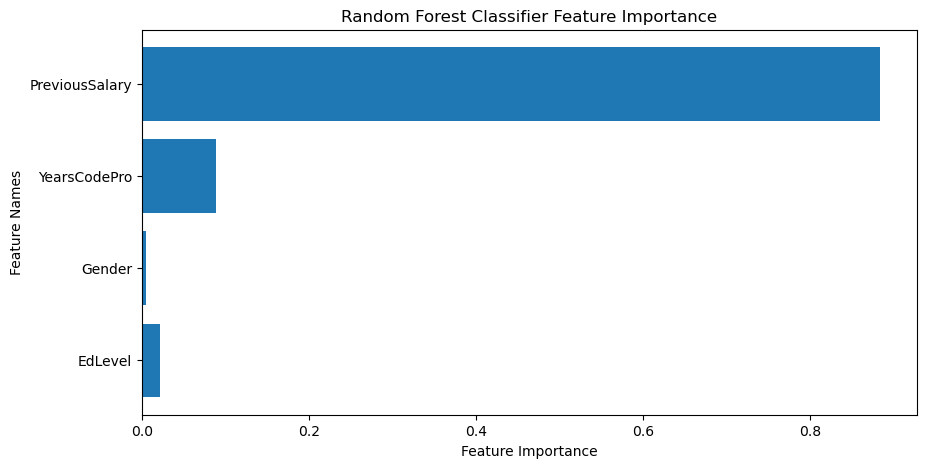

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

y_class = df["Employed"]  # Employed (1) or not (0)


# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=0)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
rf_classifier.fit(X_train, y_train_class)

# Predictions
y_pred_class = rf_classifier.predict(X_test)

# Classification Accuracy
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")
# Feature Importance Plot for Classification Model
plt.figure(figsize=(10, 5))
plt.barh(X.columns, rf_classifier.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Random Forest Classifier Feature Importance")
plt.show()
